# Folktails energy planning

It is evident that the ultimate source of energy for Folktails are windmills. This migty structures produces ultimately clean energy... unless it is a dead calm. The array of batteries solve the problem, but you need to calculate it properly, especially, if you want to minimize the number of windmills and batteries.

Thankfully, the math gives us some tools to calculate the robustness of your system. At the end there will be chart that would help you to plan your energy system responsibly. But first, we need to dive into math modelling.

## Math model

### Energy system

Whenever you build the generator, you want to balance the energy production and its consumption. Let us denote the consumption as $c$ and production as $p$. Thus, you just solve the following inequality

$$np \geq c, $$

where $n \in \mathbb{N}$ is the number of windmills.

Considering that the windmills have the wind strength thresholds [[1]](https://timberborn.wiki.gg/wiki/Large_Windmill), we can define the energy production as following

$$p = p_{\max}H(w_t - w_{\text{th}})w_t, $$


where:

$p_{\max}$ is the maximum energy output of the single windmill;

$w_{\text{th}}$ is the windmill threshold;

$w_t \in [0,1]$ is the wind strength;

$H(x)$ is the [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function).

Speaking of model, we want to find two parameters: safety factor of the generation ($f_g$) and safety factor of the batteries capacity ($f_b$). we can define them as

$$
f_g = \frac{np_{\max}}{c}; \\
f_b = \frac{b_{\max}}{c},
$$

where $b_{\max}$ is the maximum capacity of all batteries.

The $f_g$ is dimensionless, while the unit of $f_b$ is hour.

Then, the model of the energy system is the following:

$$
\begin{cases}
b_0 = 0.5b_{\max}; \\
b_{t+1} = \text{clip}(b_t + p_t - c, 0, b_{\max})\Delta\tau, \forall t \in [1, T] \subset \mathbb{N}, \\
p_t = np_{\max} H(w_t - w_{\text{th}})w_t; \\
\end{cases}
$$

where:

$\text{clip}(x, a, b) = \min(\max(x, a), b)$ is the clipping function;

$T$ is the simulation duration;

$\Delta\tau$ is the simulation step (for simplicity $\Delta\tau=1\text{h}$).

The initial battery charge is set to 50% to approximate the steady process of the battery array building. With this approximation we assume that the batteries are put on service at the constant rate.

Using the factors above, the system above can be transformed to

$$
\begin{cases}
b_t = b_{\max}\cdot\beta_t = cf_g\beta_t; \\
p_t \sim cf_p\cdot\mathcal{U}(0,1), 
\end{cases}

\Rightarrow

\begin{cases}
\beta_0 = 0.5 f_b; \\
\beta_{t+1} = \text{clip}(\beta_t + f_g\rho_t - 1, 0, f_b)\Delta\tau, \forall t \in [1, T] \subset \mathbb{N}; \\
\rho_t = H(w_t - w_{\text{th}})w_t,
\end{cases}
$$

where:

$\beta_t$ is the normalized stored energy;

$\rho_t$ is the normalized energy generation.

We consider, that the system is uptime if

$$f_b \beta_t + f_g\rho_t - 1 \geq 0.$$

Then, the uptime rate is

$$u=\frac{1}{T}\sum^T_{t=1}\mathbb{1}[f_b \beta_t + f_g\rho_t - 1 \geq 0],$$

where $\mathbb{1}(x)$ is the [indicator function](https://en.wikipedia.org/wiki/Indicator_function).

### Wind

It is known the wind strength is distributed uniformly from 0% to 100% [[2]](https://timberborn.wiki.gg/wiki/Wind). Another property of the wind is the duration that is distirbuted uniformly from 5 to 12 hours [[2]](https://timberborn.wiki.gg/wiki/Wind). The wind does not change its properties until the duration time exceeds.

Thus, the wind strength is defined according to the following scheme:

```python

t = 0
for tau in range(T):
    if t == tau:
        w_t = np.random.uniform(0, 1)
        t += np.random.randint(5, 12)
    
    # Simulate the wind strength
    # ...
```

*We cannot define the wind strength as a function of time, because it is not a function. It is a piecewise constant function, but we do not need to define it in such way, so we just define it with a pseudocode.*

## Code

To evaluate the system's behaviour, we use the Python language with some libraries.

In [5]:
import os

from matplotlib import pyplot as plt
from matplotlib.figure import Figure
import numpy as np
import torch
from tqdm.contrib.itertools import product

In [6]:
class System:
    def __init__(
        self,
        generation_factor: float = 2,
        battery_factor: float = 24,
        t: int = 10_000,
        n: int = 10_000,
        windmill_size: str = "large",
        seed: int | None = None,
    ) -> None:
        self.f_g = generation_factor
        self.f_b = battery_factor
        self.t = t
        self.n = n

        if windmill_size not in ["small", "large"]:
            raise ValueError("Invalid windmill size. Choose 'small' or 'large'.")
        self.th = 0.3 if windmill_size == "small" else 0.2
        # Initialize the random generator
        if seed is not None:
            torch.manual_seed(seed)
        # Check if GPU is available and move tensors to GPU if it is
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        # We assume that the batteries are at full charge at the initial moment
        self.battery = torch.full((self.n,), self.f_b / 2, device=self.device)

    @torch.no_grad()
    def compute(self) -> float:
        uptime = torch.tensor(0, device=self.device)
        wind_change = 0
        for tau in range(self.t):
            if tau == wind_change:
                # Sample the wind strength
                p = torch.rand(self.n, device=self.device)
                # Account threshold
                p[p < self.th] = 0
                # Sample next wind change moment
                wind_change += np.random.randint(5, 12, size=1)[0]
            # Calculate the energy production
            state = self.battery + self.f_g * p - 1
            uptime += torch.sum(state >= 0)
            # Update the stored energy
            self.battery = torch.clamp(state, 0, self.f_b)
        # Compute the rate
        rate = uptime.item() / (self.t * self.n)
        return rate

In [7]:
sys = System()
print(f"The uptime of the energy system is {sys.compute():.2%}")

The uptime of the energy system is 87.63%


Now we need to iterate over all possible combinations of $f_g$ and $f_b$ Let's consider the following limits:

$$
\begin{cases}
f_g \in [1, 4]; \\
f_b \in [0, 120],
\end{cases}
$$

thus we check all possible batteries relative capacities from none to 120 hours (5 days) of full system's consumption.

In [8]:
FP_MIN, FP_MAX, FP_STEP = 1.0, 4.0, 0.05
FB_MIN, FB_MAX, FB_STEP = 0, 5, 1 / 24

SEED = 42
T = 10_000
N = 1_000_000

production = np.arange(FP_MIN, FP_MAX + FP_STEP, FP_STEP)
capacity = np.arange(FB_MIN, FB_MAX + FB_STEP, FB_STEP)

battery, generation = np.meshgrid(capacity, production)
x_span, y_span = battery.shape

Save the results, as it takes ~3 hours to compute all the chart at Nvidia P100.

In [ ]:
os.makedirs("./results", exist_ok=True)
np.save("./results/battery-factor.npy", battery)
np.save("./results/generation-factor.npy", generation)

In [ ]:
for size in ["small", "large"]:
    uptime = np.zeros_like(battery, dtype=float)
    for x, y in product(
        range(x_span), range(y_span), desc=f"Computing for {size} windmills"
    ):
        generation_factor = generation[x, 0]
        battery_factor = 24 * battery[0, y]
        sys = System(
            generation_factor=generation_factor,
            battery_factor=battery_factor,
            t=T,
            n=N,
            windmill_size=size,
            seed=SEED,
        )
        uptime[x, y] = sys.compute()

    np.save(f"./results/uptime-{size}.npy", uptime)

## Charts

In [49]:
def plot_chart(
    generation: np.ndarray,
    battery: np.ndarray,
    uptime: np.ndarray,
    title: str = "Folktails energy system chart",
) -> Figure:
    # Plot the chart

    X_STEP = 0.1
    Y_STEP = 0.25

    fig = plt.figure(figsize=(16, 9))

    levels = np.arange(0, 101, 10)
    plt.contourf(generation, battery, uptime, cmap="turbo_r", levels=levels)
    plt.colorbar(label="Uptime [%]", ticks=levels, fraction=0.05)

    isolines = [i for i in range(0, 90, 10)] + [90, 95, 99, 99.5, 99.9, 99.99, 99.999]

    colors = ["w"] * 2 + ["k"] * (len(isolines) - 9) + ["w"] * 7

    cs = plt.contour(generation, battery, uptime, isolines, colors=colors)
    plt.clabel(cs)

    plt.xlabel("Generation factor $f_g$")
    plt.xticks(np.arange(generation.min(), generation.max(), X_STEP))

    plt.ylabel("Battery capacity factor $f_b$ [days]")
    plt.yticks(np.arange(battery.min(), battery.max() + Y_STEP, Y_STEP))

    plt.title(title, fontsize=18)
    plt.grid()
    plt.tight_layout()

    return fig

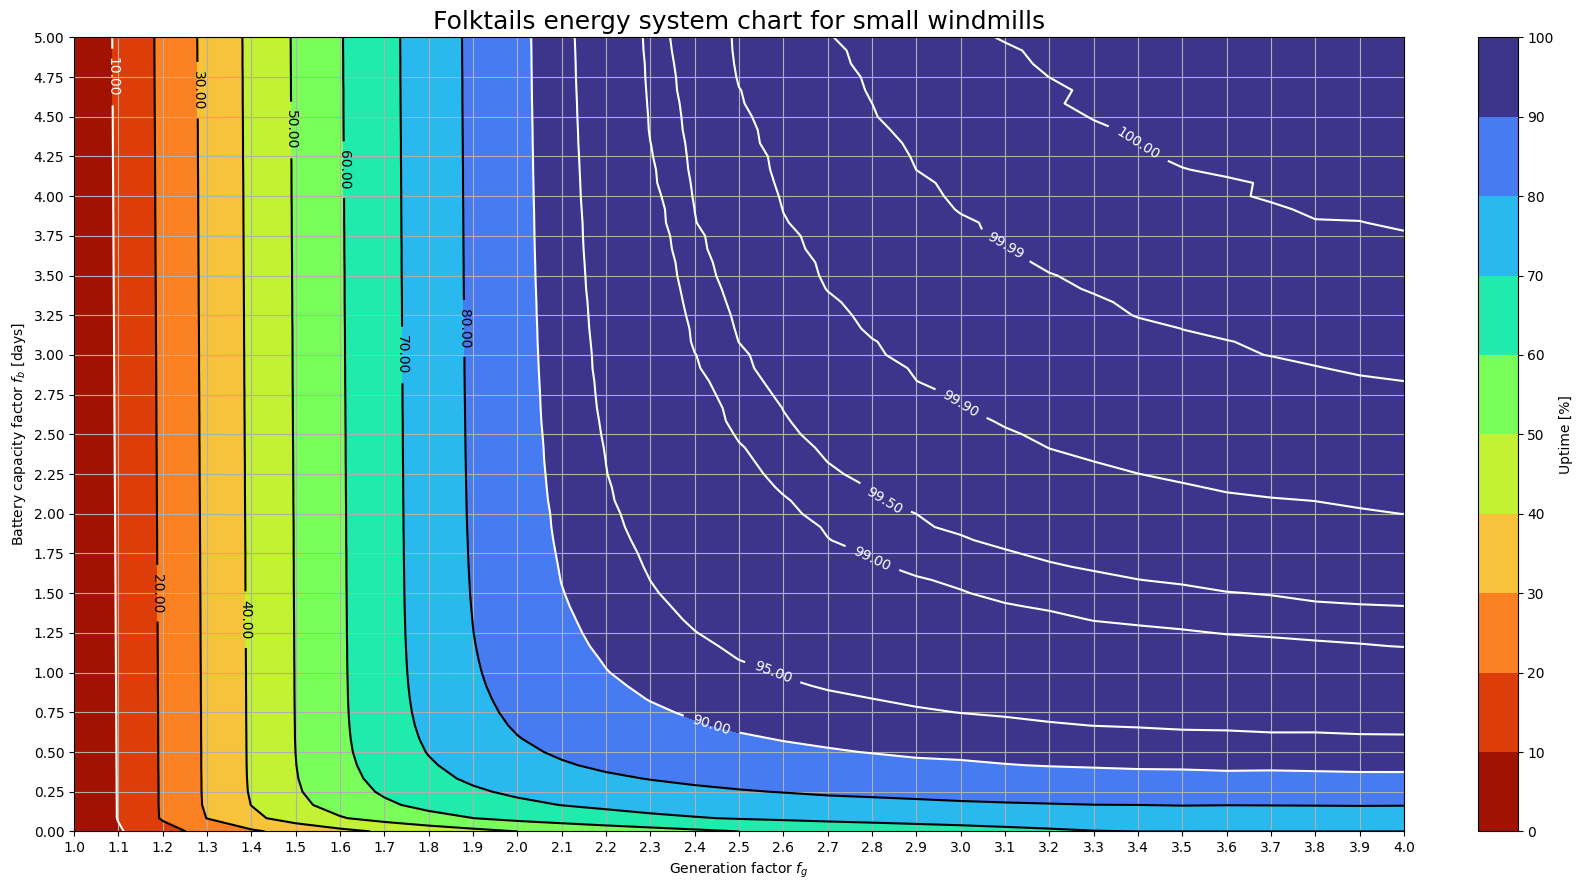

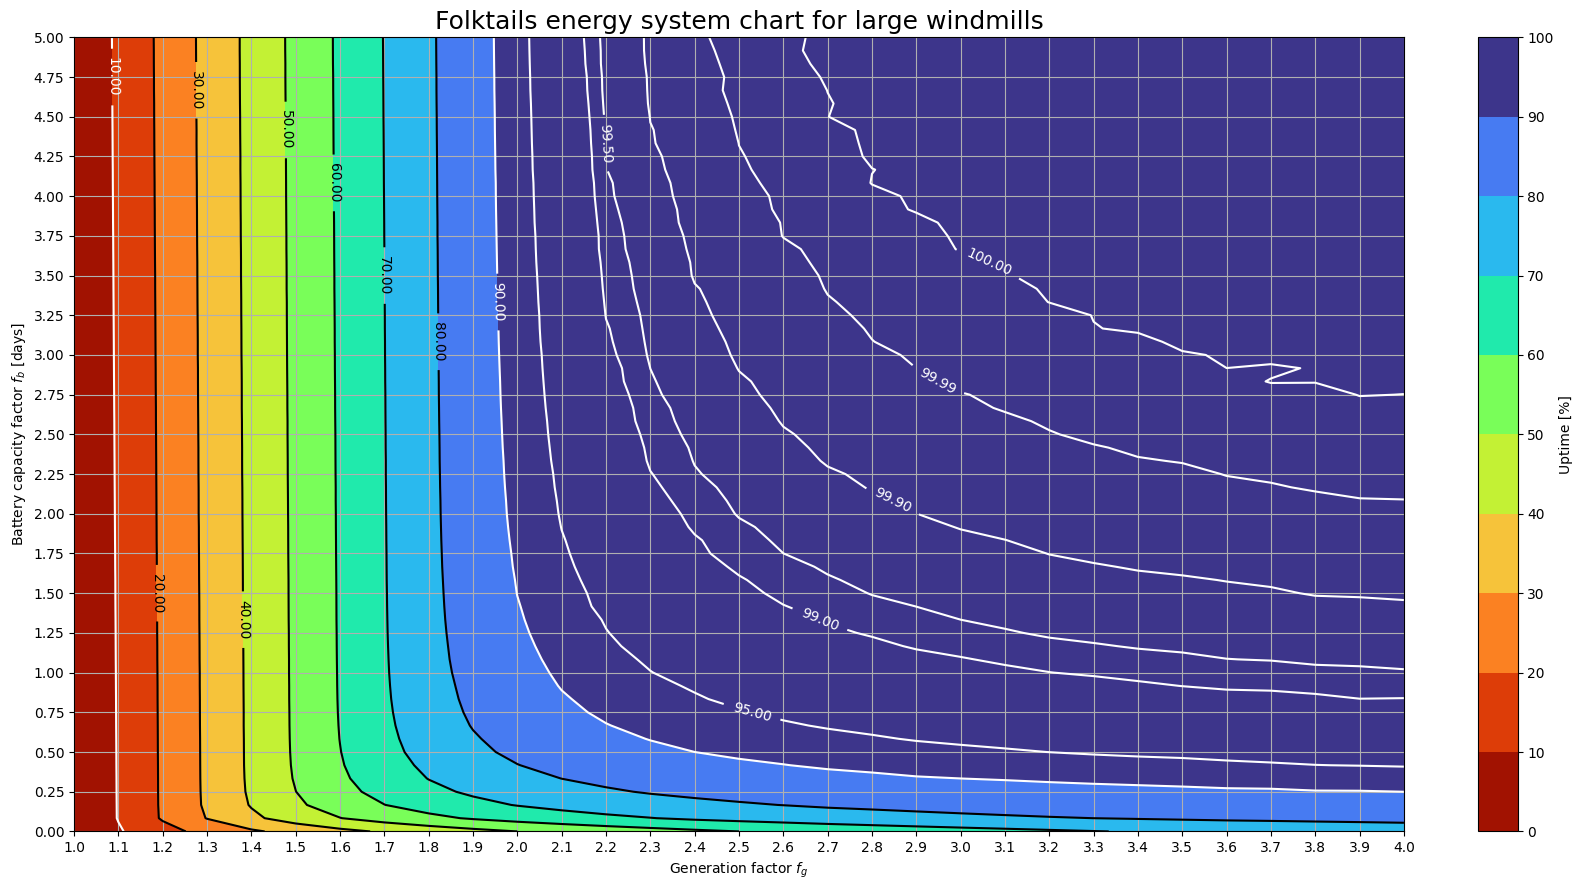

In [50]:
generation = np.load("./results/generation-factor.npy")
battery = np.load("./results/battery-factor.npy")

for size in ["small", "large"]:
    title = f"Folktails energy system chart for {size} windmills"
    uptime = np.load(f"./results/uptime-{size}.npy")
    fig = plot_chart(generation, battery, uptime * 100, title)
    fig.savefig(f"./results/chart-windmill-{size}.jpg", dpi=300)

### How to use it?

You have two parameters:
- *Generation factor* $f_g$ - a ratio between windmills **maximum** power generation and colony power consumption;
- *Battery capacity factor* $f_b$ - a ratio between batteries capacity and colony **daily** consumption (e.g. how long can your colony last using the batteries only).

#### Example
You have a colony that consumes $2000 \text{ hp}$. You have 10 large windmills with maximum power generation of $400 \text{ hp}$ units each. Thus, the generation factor is 

$$f_g = \frac{10\cdot400}{2000} = 2.$$ 

The batteries have a capacity of $96000 \text{ hph}$, so the battery capacity factor is 

$$f_b = \frac{96000}{2000 \cdot 24} = 2 \text{ days}.$$

The lower chart shows that the uptime rate for $f_g = 2$ and $f_b = 2$ with large windmills is greater than $90\%$. Thus, you can be sure that the chance of the system failure is less than $10%$.

You can increase the robustenss of the system by either adding more windmills or batteries. The chart shows that it is cheaper to add windmills, as by adding one more windmill you increase the $f_g$ to $2.2$, thus increasing the uptime rate to $95\%$.

## Take-aways

1. While your system runs on windmills only, the addition of batteries is the best way to increase the uptime rate. The chart shows that it is more effectively to add more batteries are more effective than windmills whenever your generation factor $f_g > 2.1$.
2. While your generation factor $f_g < 2.1$, the best way to increase the uptime rate is to add more windmills, as the addition of batteries is not effective.
3. As soon as you reach the $f_g = 2.1$ and $f_b = 1$, the best way to increase the uptime rate is to add proportionally more windmills and batteries.


## References

[1] https://timberborn.wiki.gg/wiki/Large_Windmill

[2] https://timberborn.wiki.gg/wiki/Wind